## LandTrendr Implementation for High Resolution LULC Information

# Requirements: 

* geemap
* ee
* matplotlib
* numpy
* pandas
* oeel ** 

The notebook uses the temporal segmentation algorithm LandTrendr to generate rasters with timeseries of specified bands and indices. Segmentation parameters are balanced to detect trend and trend breaks in spiky landsat timeseries. 

This version uses the latest processing efforts of the Landsat TM+ ETM+ and OLI collection 2

** this package allows the user to run GEE modules directly without translating JS to Python

In [2]:
%config IPCompleter.use_jedi = False

import ee
import geemap
from ipygee import chart as chart
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymannkendall as mk
import xarray as xr

 # GEE Authentication
 
 - The ee.authenticate line is necessary the first time using ee and requires the user to log into their own Earth Engine account which will allow access to a personal authentication code. 
 - Subsequent useage of this notebook should retain authentication for some time.
 - Comment and un-comment the authenticate command where required
 
 running the cell below runs the authentication process. (time with an EE account <30s)
 
 ### Paste the verification code into the box below. 
 
 (press enter to save token, comment out this box until prompted again )

In [3]:
#ee.Authenticate()

In [4]:
geemap.ee_initialize()

In [9]:
oeel = geemap.requireJS()

Map = geemap.Map()

#github_url = 'https://github.com/eMapR/LT-GEE/blob/master/LandTrendr.js'

!git clone https://code.earthengine.google.com/?accept_repo=users/mohanrahan/CATAPUC_II

Cloning into 'CATAPUC_II'...
fatal: unable to update url base from redirection:
  asked for: https://code.earthengine.google.com/?accept_repo=users/mohanrahan/CATAPUC_II/info/refs&service=git-upload-pack
   redirect: https://accounts.google.com/v3/signin/identifier?dsh=S1728951885%3A1676046874555137&continue=https%3A%2F%2Fuc.appengine.google.com%2F_ah%2Fconflogin%3Fstate%3D%7EAJKiYcFpBWrcFKP0D93jIEE8LpEXN7To0SQgD6LudmIGm8wxgyguVLDovR4u6mlUMCB3ZQaosYnOrSkT8_1rarMKkAgScOzLDw9ZL2jbnmaDUZxrtIqIBacBIu7LaYwIAAn4OUFr_lIpwDz1HV3Zm2pPyAZe4jPTtC9vPLDIqzXs1zKxeHXP_HFP3eqqcned1xF2L7iEpmApZ3d-f7bAnDvDV1IoU_OPII49V_1u3rxUXMvf3rDHMywa4jaHyfo0gclNb0fmm70-&passive=true&flowName=WebLiteSignIn&flowEntry=ServiceLogin&ifkv=AWnogHegoy0nZ3h_SMJNVF8tB0YZoHKxGeHeDwQzZPkbQzI8Qp6wLtISO6SXZSH_SxhK6bhZRKGeVg


In [8]:
github_url = 'https://code.earthengine.google.com/88419144903e303c62f236cbd0c16605'

ltgee = geemap.requireJS(github_url)

#ltgee.availability   # This command lists all the functions within the LandTrenr Module

#ltgee.version   # This command accesses the version function (prints the version of the LandTrendr module

FileNotFoundError: [Errno 2] No such file or directory: 'identifier?dsh=S-1525770697%3A1676046764283807&continue=https%3A%2F%2Fuc.appengine.google.com%2F_ah%2Fconflogin%3Fstate%3D~AJKiYcEXLHwyLVuNAKxQ9D38wjd3veeNcA5mAfOfapV4ETsq1mZfH7ubZOtH38zAcjHA02Lvb7LVEn0-3c8rd8FAmzUAYxObBnGkXFa9knkkHgMWmcxxdR-QOpd3jnEwQQwXRTWinpo7AYqM9in7AWrmOZ49-9hQhyyHBeWQ3zHbmBHu6SnUX27edhSPUEEChGuE5LvQ7KpKDzYJmfCthNWCot7bJxNWyebxYjIdHwDDbQ8ak_0cH1U&passive=true&flowName=WebLiteSignIn&flowEntry=ServiceLogin&ifkv=AWnogHfcrX78x-BwoAo-c8MSsiVhITQKufNP1GyWLl_SdTgQxEAUDAY6Ou3kutPhAbAV6oaNvuSBFA'

In [5]:
dataset = 'Meuse_Catchment_4326'
crs = 'EPSG:4326'
fignum = 0
RGB_VIS = {'bands':['B3','B2','B1'], 'min':0, 'max':1.5e3}

In [6]:
startYear = 1984 #TODO - user input

endYear = 2022 #TODO - user input

startDay = '06-20' #TODO - user input

endDay = '08-31' #TODO - user input

index = 'NDVI'
# maskOptions = ['cloud', 'shadow', 'snow', 'water', 'waterplus','nonforest']

maskThese = ['cloud', 'shadow', 'snow', 'water'] #TODO - user input?

runParams = { 
    "maxSegments": 6,
    "spikeThreshold": 0.9,
    "vertexCountOvershoot": 3,
    "preventOneYearRecovery": True,
    "recoveryThreshold": 0.25,
    "pvalThreshold": 0.05,
    "bestModelProportion": 0.75,
    "minObservationsNeeded": 6
}

ftv_list = [
    'NDVI', # normalized diff vegetation index
    'NDFI',
    'NDMI',
    'EVI', # enhanced vegetation info
    'TCB',
    'TCW',
    'TCG',
    'TCA',
    'B1',
    'B2',
    'B3',
    'B4', # LS band 4, red
    'B5', # LS band 5, near-infrared
    'B7'
]


## The Table Data

- Here the table, a vector of catchments, is loaded from the users' assets in earth engine 

#TODO rewrite to a local .shp

- The area is calculated of each shape and ranked per area, assuming that the largest is the most computationally expensive
- This is done so that we can iterate from smallest to largest, or the opposite, should any memory issues become apparent.

In [7]:
table = ee.FeatureCollection(f"projects/mohanrahan/assets/{dataset}")

def set_area_m2(feature):
    area = feature.geometry().area()
    setting = feature.set('area_m2', area)
    return setting

table_area = table.map(set_area_m2)

Filtered_Sorted = table_area.filter(ee.Filter.gt('area_m2', 0)).sort('area_m2', False)  # true ranks from smallest to largest

area_reduced = Filtered_Sorted.reduceToImage(['area_m2'],'mean')

geom = Filtered_Sorted.first().geometry()

sys_index = Filtered_Sorted.aggregate_array('system:index').getInfo()

ind = sys_index[0]

feature = Filtered_Sorted.filter(ee.Filter.eq('system:index', ind))

filtered_table = feature.getInfo()

aoi = feature.geometry()

print(f'-- sys_indices (sorted by column: area_m2 > 50e6 , H-->L): {len(sys_index)} indices -- \n \n{sys_index}\n')
print(f'-- first_index: -- \n \n{ind}\n')
print(f'-- filtered_table: -- \n \n{filtered_table["columns"]}\n')

-- sys_indices (sorted by column: area_m2 > 50e6 , H-->L): 44 indices -- 
 
['00000000000000000005', '00000000000000000012', '00000000000000000020', '00000000000000000004', '00000000000000000027', '00000000000000000028', '00000000000000000014', '0000000000000000000a', '00000000000000000025', '0000000000000000000f', '00000000000000000019', '00000000000000000011', '00000000000000000003', '00000000000000000015', '00000000000000000029', '00000000000000000023', '0000000000000000002a', '00000000000000000016', '0000000000000000002b', '0000000000000000001a', '00000000000000000026', '00000000000000000010', '00000000000000000002', '0000000000000000001e', '00000000000000000017', '00000000000000000013', '00000000000000000008', '00000000000000000024', '00000000000000000018', '0000000000000000000d', '0000000000000000001d', '0000000000000000001b', '0000000000000000000c', '00000000000000000009', '0000000000000000001c', '00000000000000000007', '00000000000000000022', '00000000000000000021', '0000000000

In [8]:
Map = geemap.Map()

Map.centerObject(aoi, 8)

for ind in sys_index:
    aoi = Filtered_Sorted.filter(ee.Filter.eq('system:index', ind))
    Map.addLayer(aoi, {}, index[18:])
    
    print(f'index: {ind}')
    
    #if ind == '00000000000000000007':
    #    break
    
    if ind == '00000000000000000005':
        break

Map

index: 00000000000000000005


Map(center=[51.10260650034179, 6.142111599095205], controls=(WidgetControl(options=['position', 'transparent_b…

In [9]:
def get_segment_data(lt: ee.Image, index: str, right: bool = False) -> ee.Image:
    """
    Given a Landtrendr output, the index of interest, and a boolean flag
    denoting whether or not to reorient inverted index values, return an ee.Image
    object containing information on the segments during which Landtrendr
    detected losses in forest cover.
    Parameters
    ----------
    lt: ee.Image
        The Landtrendr output as an ee.Image object.
    index: str
        The spectral index for which Landtrendr was run.
    right: boolean
        Whether or not to correct the orientation of the index if it has been
        inverted in the process of preparing the Landtrendr collection (see:
        https://emapr.github.io/LT-GEE/api.html#buildltcollection)
    Returns
    -------
    ee.Image
        An image with information on the loss segments as array-valued pixels.
    Python attempt at implementing:
    https://emapr.github.io/LT-GEE/api.html#getsegmentdata"""
    lt_output = lt.select("LandTrendr")
    vertex_mask = lt_output.arraySlice(0, 3, 4)
    vertices = lt_output.arrayMask(vertex_mask)

    try:
        index_info = INDEX_DICT[index]
    except KeyError:
        if index in ["NDSI", "NDMI", "TCB", "TCG", "TCW", "TCA", "NBR2"]:
            # If users provide a valid spectral index, they should get a more helpful
            # exception explaining the source of the issue than just a random KeyError
            raise NotImplementedError(
                f"The index '{index}' is not currently supported. Supported indices are: "
                + ", ".join(list(INDEX_DICT.keys()))
            )
        else:
            raise RuntimeError(
                f"The value '{index}' was not recognized as a standard spectral index."
            )

    if right:
        dist_dir = index_info["dist_dir"]
    else:
        dist_dir = 1

    left = vertices.arraySlice(1, 0, -1)
    right = vertices.arraySlice(1, 1, None)
    start_year = left.arraySlice(0, 0, 1)
    start_val = left.arraySlice(0, 2, 3).multiply(dist_dir)
    end_year = right.arraySlice(0, 0, 1)
    end_val = right.arraySlice(0, 2, 3).multiply(dist_dir)

    dur = end_year.subtract(start_year)
    mag = end_val.subtract(start_val).multiply(dist_dir)
    rate = mag.divide(dur)
    dsnr = mag.divide(lt.select("rmse"))

    seg_info = (
        ee.Image.cat(
            [start_year.add(1), end_year, start_val, end_val, mag, dur, rate, dsnr]
        )
        .toArray(0)
        .updateMask(vertex_mask.mask())
    )

    # FIXME: add filter on magnitude here to restrict to only loss segments

    return seg_info

def extract_deforestation_events(
    LT_segments: ee.Image, start_year: int, end_year: int, dsnr_threshold: float
) -> ee.Image:
    """
    Given an image with information about loss segments, assumed to be the
    output of get_segment_data, bounds on start and end year, and a threshold
    on the disturbance signal-to-noise ratio (DSNR), filter to only events
    within the years of interest which pass the DSNR threshold.
    Note: the decision to extract the most recent event, rather than the
    selecting the largest or using a different selection mechanism, is made
    because this was written with the goal of identifying deforestation events
    followed by a recovery period.
    Parameters
    ----------
    LT_segments: ee.Image
        Landtrendr segment data, assumed to be the output of get_segment_data
    start_year: int
        The first year to consider for deforestation events.
    end_year: int
        The last year to consider for deforestation events.
    dsnr_threshold: float
        The threshold on the disturbance signal-to-noise ratio (DSNR) for the
        deforestation segments.
    Returns
    -------
    ee.Image
        The input image filtered to the most recent event in each pixel which
        passes the given threshold.
    """
    start_years = LT_segments.arraySlice(0, 0, 1)
    end_years = LT_segments.arraySlice(0, 1, 2)
    dsnr = LT_segments.arraySlice(0, 7, 8)
    mask = (
        start_years.gte(ee.Image(start_year))
        .And(end_years.lte(ee.Image(end_year)))
        .And(dsnr.gte(ee.Image(dsnr_threshold)))
    )

    masked_segments = LT_segments.arrayMask(mask)

    # Extract the most recent segments for each pixel
    # factor of -1 to flip delta, since arraySort is ascending
    sort_by = masked_segments.arraySlice(0, 0, 1).toArray(0).multiply(-1)
    segments_sorted = masked_segments.arraySort(sort_by)
    return segments_sorted.arraySlice(1, 0, 1)

def zonal_summary(image, geometry, scale):
    summary = image.reduceRegion(**{
    'reducer':ee.Reducer.median(),
    'geometry':aoi,
    'scale':scale,})
    return summary

def zonal_array(image, geometry, scale):
    summary = image.reduceRegion(**{
    'reducer':ee.Reducer.toList(),
    'geometry':aoi,
    'scale':scale,})
    return summary

def get_arrays(lt: ee.Image, select: str):
    if select=='LandTrendr':
        lt_output = lt.select("LandTrendr")
        years_mask = lt_output.arraySlice(0, 0, 1)
        array = lt_output.arrayMask(years_mask)
    
    if select=='rmse':
        lt_output = lt.select("rmse")
        array = lt_output

    return array.toArray() 
    


def extract_deforested_regions(
    LT_result: ee.Image,
    index: str,
    start_year: int,
    end_year: int,
    dsnr_threshold: float,
):
    """
    Given the output of Landtrendr as an image, the index of interest, bounds on
    the beginning and end of the period to identify events, and a threshold on
    the DSNR, return a flattened image containing information about the most
    recent deforestation event in each pixel which passes the specified DSNR
    threshold.
    Note: the decision to extract the most recent event, rather than the
    selecting the largest or using a different selection mechanism, is made
    because this was written with the goal of identifying deforestation events
    followed by a recovery period.
    Parameters
    ----------
    LT_segments: ee.Image
        Landtrendr segment data, assumed to be the output of get_segment_data
    index: str
        The spectral index for which Landtrendr was run.
    start_year: int
        The first year to consider for deforestation events.
    end_year: int
        The last year to consider for deforestation events.
    dsnr_threshold: float
        The threshold on the disturbance signal-to-noise ratio (DSNR) for the
        deforestation segments.
    """
    LT_segments = get_segment_data(LT_result, index, True)
    events = extract_deforestation_events(
        LT_segments, start_year, end_year, dsnr_threshold
    )

    flattened_image = ee.Image.cat(
        events.arraySlice(0, 0, 1).arrayProject([1]).arrayFlatten([["yod"]]),
        events.arraySlice(0, 1, 2).arrayProject([1]).arrayFlatten([["endYr"]]),
        events.arraySlice(0, 2, 3).arrayProject([1]).arrayFlatten([["startVal"]]),
        events.arraySlice(0, 3, 4).arrayProject([1]).arrayFlatten([["endVal"]]),
        events.arraySlice(0, 4, 5).arrayProject([1]).arrayFlatten([["mag"]]),
        events.arraySlice(0, 5, 6).arrayProject([1]).arrayFlatten([["dur"]]),
        events.arraySlice(0, 6, 7).arrayProject([1]).arrayFlatten([["rate"]]),
        events.arraySlice(0, 7, 8).arrayProject([1]).arrayFlatten([["dsnr"]]),
    )

    return flattened_image

def _extract_and_append_date(image: ee.Image, input_list: ee.List) -> ee.List:
    """Given an ee.Image and an ee.List, append the image's date to the list."""
    date = image.date()
    return ee.List(input_list).add(ee.Date(date))



def _create_yearly_list(collection: ee.ImageCollection) -> ee.List:
    """Given an ee.ImageCollection, return an ee.List containing all the (unique)
    years present in the collection."""
    dates = collection.iterate(_extract_and_append_date, ee.List([]))

    years = ee.List(dates).map(lambda date: ee.Date(date).get("year")).distinct().sort()

    return years

def _generate_medoid_collection(
    collection: ee.ImageCollection, start_day: str, end_day: str
) -> ee.ImageCollection:
    """Given an ee.ImageCollection and bounds on the start and end days, compute
    an ee.ImageCollection which contains a medoid image for each year present in
    the input collection.
    Parameters
    ----------
    collection: ee.ImageCollection
      The collection whose medoid should be calculated.
    start_day: str
      The first day, inclusive, to consider in calculating the medoid. Formatted
      as 'mm-dd'.
    end_day: str
      The last day, inclusive, to consider in calculating the medoid. Formatted as
      'mm-dd'.
    Returns
    -------
    ee.ImageCollection
      A collection of yearly medoid images for the provided collection.
    """

    years = _create_yearly_list(collection)

    def _extract_medoid(year):
        return _extract_medoid_image(year, collection, start_day, end_day)

    images = years.map(_extract_medoid)
    return ee.ImageCollection.fromImages(images)

def _extract_medoid_image(
    year: int,
    collection: ee.ImageCollection,
    start_day: str = startDay,
    end_day: str = endDay,
) -> ee.Image:
    """Given a year of interest, an ee.ImageCollection, and boundaries of start
    and end days, return an ee.Image which is the medoid image for the year in
    question. Distance calculated using the standard Euclidean norm across all
    6 TM-equivalent bands. Question: is it possible to do better, for the purposes
    of a deforestation analysis, by applying a higher weight to NIR and SWIR bands?
    Parameters
    ----------
    year: int
      The year for which the medoid should be calculated.
    collection: ee.ImageCollection[]
      The collection whose medoid should be calculated.
    start_day: str
      The first day, inclusive, to consider in calculating the medoid. Formatted
      as 'mm-dd'.
    end_day: str
      The last day, inclusive, to consider in calculating the medoid. Formatted as
      'mm-dd'.
    Returns
    -------
    ee.Image
      An ee.Image containing the pixel-wise medoid for the year in question.
    """
    bandNum =collection.first().bandNames().length().getInfo()
    
    start_m, start_d = start_day.split("-")
    end_m, end_d = end_day.split("-")

    start_date = ee.Date.fromYMD(ee.Number(year), int(start_m), int(start_d))
    end_date = ee.Date.fromYMD(ee.Number(year), int(end_m), int(end_d)).advance(
        1, "day"
    )
    filtered_collection = collection.filterDate(start_date, end_date)
    empty_col = ee.ImageCollection([ee.Image([0,0,0,0,0,0]).mask(ee.Image(0))]);
    non_empty = filtered_collection.toList(1).length().gt(0)
    final_collection = ee.ImageCollection(ee.Algorithms.If(non_empty, filtered_collection, empty_col))
    median = final_collection.median()

    def _euclidean_distance(image: ee.Image) -> ee.Image:
        distance = ee.Image(image).subtract(median).pow(ee.Image.constant(2))
        return distance.reduce("sum").addBands(image)

    distance_from_median = final_collection.map(_euclidean_distance)
    return (
        ee.ImageCollection(distance_from_median)
        .reduce(ee.Reducer.min())
        .set("system:time_start", ee.Date.fromYMD(year, 8, 1).millis())
    )


## Running LandTrendr over the Shapefile

1. The geometries are called by their system indices updating the 'aoi'
2. The image collection is generated per shapefile and then returns the decadal mean

In [10]:
imcol = 0

for ind in sys_index:
    
    geom_name = ind[16:]
    
    dataset_name = dataset[0:5]
    
    print(f'{dataset_name} catchment, index: {ind}')
    
    #aoi = Filtered_Sorted.filter(ee.Filter.eq('system:index', ind)).geometry()
    
#    aoi = ee.Geometry.Polygon(
#        [[[-122.7529907662841, 44.28122923395663],
#          [-122.74904255461418, 44.28092199297525],
#          [-122.74912838530265, 44.287127949226864],
#          [-122.75908474516594, 44.28688218124931]]]);
    
    """
    the landsat surface reflectance collection builds a combined landsat collection, harmonized, clipped and reduced to medoid
    """
    
    imcol = ltgee.buildSRcollection(startYear, endYear, startDay, endDay, aoi, maskThese)
    
    print(f'imcol generated {geom_name}')
    
    LTcol = ltgee.buildLTcollection(imcol, index, ftv_list)
    
    print(f'LTcol generated {geom_name}')
    
    #batch.Export.ImageCollection.toDrive(landsat_landtrendr_collection, 'image_collection', **{
      #  scale: 30,
        #region: aoi,
       # type:'float'
    #})
    
    
    runParams["timeSeries"] = LTcol
    
    lt = ee.Algorithms.TemporalSegmentation.LandTrendr(**runParams)
    
#    fitBandStack_img = ltgee.getFittedData(lt, startYear, endYear, index)

#    indexCollection = ltgee.transformSRcollection(imcol, ['B3', 'B4', 'NDVI'])
    

    
#    rawBandStack = collectionToBandStack(indexCollection, startYear, endYear)
    
    #rawBandStack = ltgee.collectionToBandStack(indexCollection, startYear, endYear, 'undefined')
    
#    deforested_regions = extract_deforested_regions(
#        LT_result=lt, 
#        index=index,
#        start_year=start_year, 
#        end_year=end_year, 
#        dsnr_threshold=dsnr_threshold
#        )
    
#    task = ee.batch.Export.image.toDrive(**{
#    'image': deforested_regions,
#    'description':'LT'+'_'+dataset_name+'_'+index+'_'+str(start_year)+'_'+str(end_year)+'_'+geom_name+'_'+str(scale)+'m', 
#    'folder':f'LToutput/{dataset_name}_defor/{scale}m/'+geom_name, #TODO - user input
#    'folder':f'LToutput/{dataset_name}_defor{scale}m_'+geom_name, #TODO - user input
#    'scale': scale,
#    'region': aoi,
#    'crs': crs,
#    })
    
#    task.start()
    
    
#    print(f'index: {ind} with task id: {task.id}')
#    
    if ind == '00000000000000000005':
        print(f'index: {ind} BREAK')
        break
    
    #if ind == '00000000000000000005':
    #    break


Meuse catchment, index: 00000000000000000005
imcol generated 0005
LTcol generated 0005
index: 00000000000000000005 BREAK


In [11]:
# Define a function to calculate summary statistics for a given image and geometry
def get_summary(img, geom, scale):
  return img.reduceRegion(reducer=ee.Reducer.median(), geometry=geom, scale=scale)

In [15]:
# Get the fitted data from LandTrendr
# fit_band_stack = ltgee.getFittedData(lt, startYear, endYear, index)

# # Build an annual surface reflectance collection
# annual_sr_collection = ltgee.buildSRcollection(startYear, endYear, startDay, endYear, aoi, maskThese)

# # Transform the annual surface reflectance collection to the specified band
# index_collection = ltgee.transformSRcollection(annual_sr_collection, [index])

In [16]:
# Transform the image collection of the specified band to an image band stack
# raw_band_stack = ltgee.collectionToBandStack(index_collection, startYear, endYear)

In [17]:
# fitBandStack = ltgee.getFittedData(lt, startYear, endYear, index)

In [12]:
annualSRcollection = imcol
indexCollection = ltgee.transformSRcollection(annualSRcollection, [index])

In [13]:
def get_summary(img, geom, scale):
    return img.reduceRegion(**{
    'reducer':ee.Reducer.median(),
    'geometry':aoi,
    'scale':scale,})

In [15]:
changeParams = {
    'delta':'loss',
    'sort':'greatest',
    'year':{'checked':False, 'start':2000, 'end':2010},
    'mag':{'checked':True, 'value':200, 'operator':'>', 'dsnr':False},
    'dur':{'checked':True, 'value':4, 'operator': '<'},
    'preval':{'checked':True, 'value':300, 'operator': '>'},
    'mmu': {'checked':True, 'value':11},
    }


# changeImg = ltgee.getChangeMap(**changeParams)

# palette = ['#9400D3', '#4B0082', '#0000FF', '#00FF00', '#FFFF00', '#FF7F00', '#FF0000']

# yodVisParams = {
#     'min': startYear,
#     'max': endYear, 
#     'palette': palette,
# }

# Map.centerObject(aoi, 11)

# Map.addLayer(changeImg.select(['yod']), yodVisParams, 'yod')

# Map

## Begin Comparative Analysis

above: Generated a 37 year timeseries of 7 bands, as medoid yearly summer value.

below: the controls are loaded and compared to test the overall efficacy of controls available 


In [16]:
scale = 5566 # define the pixel size for reducing, in meters, initially high to reduce comp time

In [18]:
ndvi_col = ee.ImageCollection("NOAA/CDR/AVHRR/NDVI/V5").filterBounds(aoi).filterDate(str(startYear)+'-'+startDay, str(endYear)+'-'+endDay)

ndvi_col.first()

In [51]:
lists = zonal_array(get_arrays(lt, 'LandTrendr'), aoi, scale).values().getInfo()[0][0]
years_list = lists[0] #* -1#[0:-1]
source_list = lists[1] #[0:-1]
fit_list = lists[2] #[0:-1]
vert_list = lists[3] 

print(years_list)
print(source_list)
print(fit_list)
print(vert_list)

[1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
[-701.3870002719609, -833.9602364320258, -783.3553500660502, -821.4285714285714, -796.2638645650904, -818.9845474613686, -761.1389401529133, -812.9713423831071, -556.184668989547, -787.9858657243817, -767.5204052913032, -868.2106424041908, -853.5455861070911, -861.3312202852616, -869.2988427501703, -732.9974811083123, -835.3413654618473, -817.2284644194756, -818.6412128017967, -728.4423761292089, -827.4449564772145, -837.0370370370371, -715.04724981827, -848.1781376518218, -886.7177838238931, -861.3212304589007, -835.8917108568239, -891.494002181025, -884.2934515017233, -874.2576285070653, -864.2285714285715, -857.1026722925457, -888.9400921658986, -830.9859154929577, -876.0330578512396, -862.9506520071593, -889.7795591182364, -808.3291520321125]
[-785.65971867

In [24]:
ndvi_col_arr = _generate_medoid_collection(ndvi_col, startDay, endDay) 
ndvi_col_arr.first().bandNames()

In [25]:
Map.centerObject(aoi, 12)
Map.addLayer(ndvi_col_arr.first(), {'bands':['NDVI_min'], 'min':-1, 'max':1}, 'ndvi')
Map

#ndvi_col_arr =zonal_array(ndvi_col_arr, aoi, 300)

#ndvi_col_arr.getInfo()

Map(bottom=44128.0, center=[51.10260650034179, 6.142111599095205], controls=(WidgetControl(options=['position'…

In [53]:
chart_ts_region = chart.Image.series(**{
    'imageCollection': ndvi_col_arr,
    'reducer': ee.Reducer.median(),
    'region': aoi,
    'scale': scale,
    'band': 'ndvi_min_median',
})

df = chart_ts_region.dataframe#.widget(width=800)
df_array = np.array(df.ndvi_min[:])

dates = np.array(['1984-08-01', '1985-08-01', '1986-08-01', '1987-08-01',
               '1988-08-01', '1989-08-01', '1990-08-01', '1991-08-01',
               '1992-08-01', '1993-08-01', '1994-08-01', '1995-08-01',
               '1996-08-01', '1997-08-01', '1998-08-01', '1999-08-01',
               '2000-08-01', '2001-08-01', '2002-08-01', '2003-08-01',
               '2004-08-01', '2005-08-01', '2006-08-01', '2007-08-01',
               '2008-08-01', '2009-08-01', '2010-08-01', '2011-08-01',
               '2012-08-01', '2013-08-01', '2014-08-01', '2015-08-01',
                '2017-08-01', '2018-08-01', '2019-08-01', '2020-08-01',
                '2021-08-01', '2022-08-01',])# '2023-08-01', '2020-08-01'])

Gimms_ndvi = np.zeros(len(years_list))

for i in range(len(years_list)):
    if i < len(df_array):

        Gimms_ndvi[i] =  df.ndvi_min[i]
        
    else:
 
        Gimms_ndvi[i] = -999

#print(Gimms_ndvi)

In [54]:
dataframe_dict = {'lt_year':years_list, 'source': np.array(source_list)*-1/1000, 'fit':np.array(fit_list)*-1/1000, 'vert':np.array(vert_list)*-1/1000, 'GIMMS_ndvi':np.array(Gimms_ndvi)}

df = pd.DataFrame(dataframe_dict, dates)
df_rep = df.replace(-999.00, np.nan)

df_rep


,lt_year,source,fit,vert,GIMMS_ndvi
1984-08-01,1984,0.701387,0.785660,-0.001,0.660
1985-08-01,1985,0.833960,0.788059,0.000,0.615
1986-08-01,1986,0.783355,0.790459,0.000,0.731
1987-08-01,1987,0.821429,0.792858,0.000,0.743
1988-08-01,1988,0.796264,0.795258,0.000,0.708
1989-08-01,1989,0.818985,0.797657,0.000,0.694
1990-08-01,1990,0.761139,0.800056,0.000,0.638
1991-08-01,1991,0.812971,0.802456,0.000,0.796
1992-08-01,1992,0.556185,0.804855,0.000,0.464
1993-08-01,1994,0.787986,0.809654,0.000,0.676


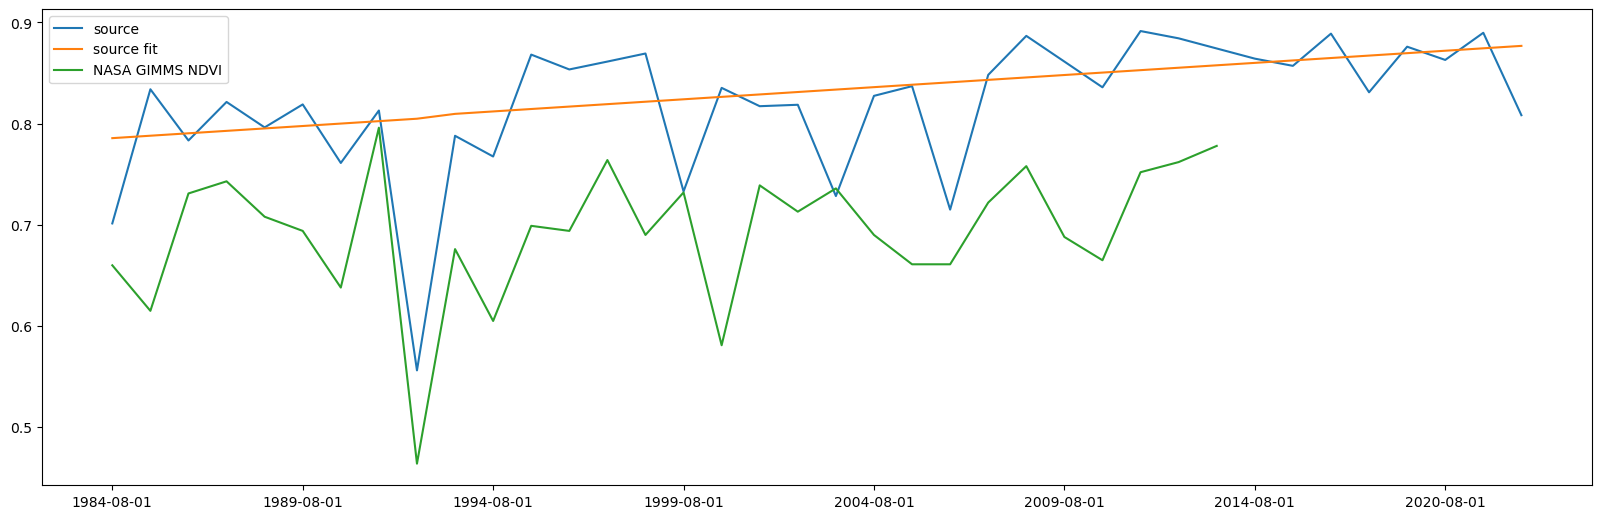

In [55]:
df_rep.source.plot(figsize=(20, 6.18))
df_rep.fit.plot(label = 'source fit')
df_rep.GIMMS_ndvi.plot(label='NASA GIMMS NDVI')

plt.legend()

In [56]:
mk.original_test(df_rep.source.iloc[:-7])

Mann_Kendall_Test(trend='increasing', h=True, p=0.002483355213678262, z=3.025362220024165, Tau=0.3849462365591398, s=179.0, var_s=3461.6666666666665, slope=0.0028395175669719444, intercept=0.7848521929726353)

In [57]:
mk.original_test(df_rep.GIMMS_ndvi)

Mann_Kendall_Test(trend='no trend', h=False, p=0.13396533563924473, z=1.4986466042941324, Tau=0.19540229885057472, s=85.0, var_s=3141.6666666666665, slope=0.002090909264304795, intercept=0.666181819005439)

In [59]:
def pandas_rmse(series_1, series_2):
    rmse_df = ((series_1 - series_2)**2).mean() ** 0.5
    return rmse_df


In [60]:
rmse_fit_source = pandas_rmse(df_rep.source, df_rep.fit)
rmse_fit_source

0.058952226284019735

In [61]:
rmse_fit_gimms = pandas_rmse(df_rep.fit, df_rep.GIMMS_ndvi)
rmse_fit_gimms

0.14320318172075072

In [62]:
rmse_source_gimms = pandas_rmse(df_rep.source, df_rep.GIMMS_ndvi)
rmse_source_gimms

0.1304879968148777

In [63]:
rmse_dict = {'r_FS':rmse_fit_source,'r_FG':rmse_fit_gimms, 'r_SG':rmse_source_gimms}

rmse_dict.values()

dict_values([0.058952226284019735, 0.14320318172075072, 0.1304879968148777])

In [64]:
LS_median = imcol.median()

In [65]:
stats_LS = geemap.image_stats(LS_median, aoi, scale=scale)
LS_col_stats = stats_LS.getInfo()

In [66]:
Map.addLayer(LS_median, RGB_VIS, '')
Map

Map(bottom=354144.0, center=[50.390241997964694, 5.252806723646078], controls=(WidgetControl(options=['positio…

In [67]:
def image_band_ts(imageCollection, scale):
    
    chart_ts_region = chart.Image.series(**{
    'imageCollection': imageCollection,
    'reducer': ee.Reducer.median(),
    'region': aoi,
    'scale': scale,
    'band': 'B1_median',
    })
    
    return chart_ts_region.dataframe



In [68]:
band_data_LS = image_band_ts(imcol, scale)

In [69]:
band_data_LS

,B1,B2,B3,B4,B5,B7
1984-08-31 22:00:00,864.465683,1177.770518,1109.027385,4124.270709,2525.039856,1364.095149
1985-08-31 22:00:00,362.749216,730.324820,539.060568,3952.776067,2024.945520,915.226556
1986-08-31 22:00:00,519.405022,857.154764,647.088584,4192.961212,2029.583226,966.044932
1987-08-31 22:00:00,419.069251,772.830149,595.640839,3850.894236,2012.215700,969.241329
1988-08-31 22:00:00,392.412965,747.130239,534.225184,3861.242045,1932.518911,916.228004
1989-08-31 22:00:00,395.906005,755.319530,613.847905,3630.560935,1928.765827,952.257856
1990-08-31 22:00:00,651.294919,955.179141,745.597714,4077.265006,2061.194580,962.264743
1991-08-31 22:00:00,438.929199,744.843692,601.212261,3761.365682,2318.534086,1078.356139
1992-08-31 22:00:00,584.599218,923.926213,761.490185,3726.328350,2153.514429,990.303096
1993-08-31 22:00:00,520.695937,857.840145,680.037888,4017.378016,2222.330426,1044.872716


## Compared the early days to some control

Now: can we see what a modern analog might be? - Sentinel 

1. Write functions for sentinel processing

In [90]:
def get_s2_sr_cld_col(aoi, S2_start_year, start_day, S2_end_year, end_day, CLOUD_FILTER):
    
    
    '''
    1. Import and filter S2 SR. 
    2. Separately import the cloud probability as collection
    '''
    
    s2_sr_col = (ee.ImageCollection('COPERNICUS/S2_SR')
        .filterBounds(aoi)
        .filterDate(ee.Date(str(S2_start_year) + "-" + start_day), ee.Date(str(S2_end_year) + "-" + end_day).advance(1, "day"))
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER))
                )

    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(aoi)
        .filterDate(ee.Date(str(S2_start_year) + "-" + start_day), ee.Date(str(S2_end_year) + "-" + end_day).advance(1, "day"))
                       )

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    return ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))


def add_cloud_bands(img):
    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb, is_cloud]))


def add_shadow_bands(img):
    # Identify water pixels from the SCL band.
    not_water = img.select('SCL').neq(6)

    # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

    # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

    # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))

    # Identify the intersection of dark pixels with cloud shadow projection.
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')

    # Add dark pixels, cloud projection, and identified shadows as image bands.
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

def add_cld_shdw_mask(img):
    # Add cloud component bands.
    img_cloud = add_cloud_bands(img)

    # Add cloud shadow component bands.
    img_cloud_shadow = add_shadow_bands(img_cloud)

    # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

    # Remove small cloud-shadow patches and dilate remaining pixels by BUFFER input.
    # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
    is_cld_shdw = (is_cld_shdw.focalMin(2).focalMax(BUFFER*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))

    # Add the final cloud-shadow mask to the image.
    return img.addBands(is_cld_shdw)

def apply_cld_shdw_mask(img):
    # Subset the cloudmask band and invert it so clouds/shadow are 0, else 1.
    not_cld_shdw = img.select('cloudmask').Not()

    # Subset reflectance bands and update their masks, return the result.
    return img.select('B.*').updateMask(not_cld_shdw)

def add_cloud_bands(img):
    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb, is_cloud]))

def maskS2clouds(image: ee.Image) -> ee.Image:
    """Apply a mask to a sentinel image to filter out cloud, snow, and cloud
    shadow pixels."""
    qa_band = image.select("QA60")

    opaque_bit_msk = 1 << 10
    cirrus_bit_msk = 1 << 11

    qa_mask = (
        qa_band.bitwiseAnd(opaque_bit_msk).eq(0)
        .And(qa_band.bitwiseAnd(cirrus_bit_msk).eq(0))
    )

    return image.updateMask(qa_mask).copyProperties(image)

def clip_collection(image: ee.Image)-> ee.Image:
    
    """
    reduce the size of the image colelction to be only pixels relevant to the aoi
    """
    return image.clip(aoi).copyProperties(image)

def reduce_reproject_resample(image: ee.Image)-> ee.Image:
    
    """
    Mapping this function over a collection returns a (currently sentinel) image of resolution 30m to match the 
    """
    
    reprojected_image = image.reproject(**{'crs':crs,  'scale':30})

    reduced_image = reprojected_image.reduceResolution(**{'reducer': ee.Reducer.mean(), 'maxPixels': 1024})
    
    resampled_image = image.resample("bilinear").set("system:time_start", image.get("system:time_start"))

    return resampled_image

def band_matching(image: ee.Image)->ee.Image:
    input_bands=["B2", "B3", "B4", "B8", "B11", "B12"]
    output_bands=["B1", "B2", "B3", "B4", "B5", "B7"]
    return image.select(input_bands, output_bands)



def build_S2_cloudless_collection(
    col: ee.ImageCollection,
) -> ee.ImageCollection:
    
    """
    The sentinel collection is 
    - clip_collection: reduce the collection size to images relevant to the aoi only
    - reduce_reproject_resample: takes each image in the collection and resamples to match the scale and projection of the landsat collection
    - 
    """
    
    collection = (col.map(clip_collection)
        .map(reduce_reproject_resample)
        .map(band_matching),
    )
    
    return collection




In [91]:
S2_start_year = 2016
S2_end_year = endYear
CLOUD_FILTER = 20
CLD_PRB_THRESH = 40
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 2
BUFFER = 50

S2_cloudless_col = (get_s2_sr_cld_col(aoi, S2_start_year, startDay, S2_end_year, endDay, CLOUD_FILTER)
                    .map(add_cld_shdw_mask)
                    .map(apply_cld_shdw_mask)
                    .map(clip_collection)
                    .map(band_matching))


In [92]:
S2_cloudless_medoid = _generate_medoid_collection(S2_cloudless_col, startDay, endDay).select([1, 2, 3, 4, 5, 6], ["B1", "B2", "B3", "B4", "B5", "B7"])

In [137]:
S2_median = S2_cloudless_medoid.median()

stats_S2 = geemap.image_stats(S2_median, aoi, scale=scale)
S2_col_stats = stats_S2.getInfo()

In [138]:
LS_col_stats['max']

{'B1': 1702, 'B2': 2265, 'B3': 2420, 'B4': 5177, 'B5': 3311, 'B7': 2554}

In [139]:
S2_col_stats['max']

{'B1': 3890.5,
 'B2': 4327,
 'B3': 4607.5,
 'B4': 5546.5,
 'B5': 4124.5,
 'B7': 3105}

In [140]:
Map.addLayer(S2_median, RGB_VIS, 'Sentinel 2 Median')
S2_2018 = S2_cloudless_medoid.filterDate('2018-'+startDay, '2018-09-01').first()
layer = imcol.filterDate('2018-'+startDay, '2018-09-01').first().clip(aoi)
Map.addLayer(layer, RGB_VIS, '2018 layer')
Map.addLayer(S2_2018, RGB_VIS, '2018 layer')
Map

Map(bottom=1415838.0, center=[50.38126874743727, 5.265712738037109], controls=(WidgetControl(options=['positio…

In [125]:
band_data_S2 = image_band_ts(S2_cloudless_medoid, scale)
band_data_S2

,B1,B2,B3,B4,B5,B7
2017-08-01,343.671833,615.509727,495.575214,3119.133792,1967.266583,1103.958752
2018-08-01,303.541021,559.732198,367.281934,2831.656332,1679.499442,823.683020
2019-08-01,295.407416,551.363642,335.382914,2703.382257,1527.614151,743.685218
2020-08-01,327.511281,591.683258,335.364254,2959.603178,1735.365097,871.434616
2021-08-01,359.392911,679.524013,439.822681,3375.292949,1840.171442,975.616143
2022-08-01,1367.325234,1623.912943,1423.298025,3727.624170,2830.878501,1942.763293


<AxesSubplot:>

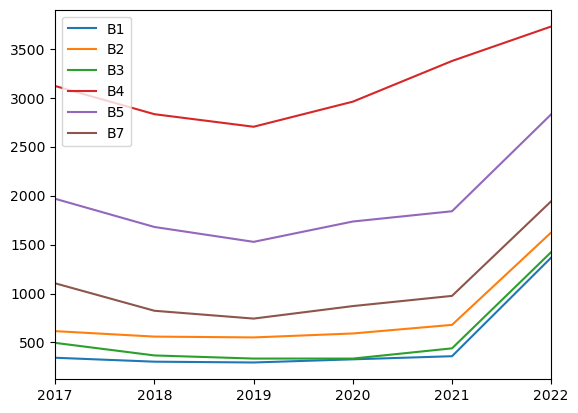

In [126]:
band_data_S2.plot()

In [127]:
pandasband_data_S2.iloc[0:-1]

,B1,B2,B3,B4,B5,B7
2017-08-01,343.671833,615.509727,495.575214,3119.133792,1967.266583,1103.958752
2018-08-01,303.541021,559.732198,367.281934,2831.656332,1679.499442,823.683020
2019-08-01,295.407416,551.363642,335.382914,2703.382257,1527.614151,743.685218
2020-08-01,327.511281,591.683258,335.364254,2959.603178,1735.365097,871.434616
2021-08-01,359.392911,679.524013,439.822681,3375.292949,1840.171442,975.616143


In [130]:
band_data_LS.iloc[-6:-1, :]

,B1,B2,B3,B4,B5,B7,NDVI,EVI,NBR,NDMI,GNDVI,NDBI
2017-08-31 22:00:00,343.597208,631.883139,551.362469,3599.370325,2000.653677,1033.712564,-0.295532,1.759184,0.553769,0.285484,0.701326,-0.285484
2018-08-31 22:00:00,483.824512,791.183331,839.253541,3567.916067,2542.949063,1448.076155,-0.241064,1.370980,0.422616,0.167729,0.636997,-0.167729
2019-08-31 22:00:00,375.466165,663.580036,551.277077,3375.639216,2094.915469,1126.916697,-0.277287,1.825323,0.499432,0.234112,0.671432,-0.234112
2020-08-31 22:00:00,367.895732,654.992663,623.015627,3341.821941,2190.396264,1197.312030,-0.280673,1.572765,0.472449,0.208131,0.672243,-0.208131
2021-08-31 22:00:00,312.647585,664.522863,489.219345,3819.268311,1808.165541,885.486814,-0.360096,1.887471,0.623578,0.357375,0.703589,-0.357375


92.44195539842754
118.88090677450103
267.455808874949
559.9714723267294
505.28575533749284
362.21183430711375


''

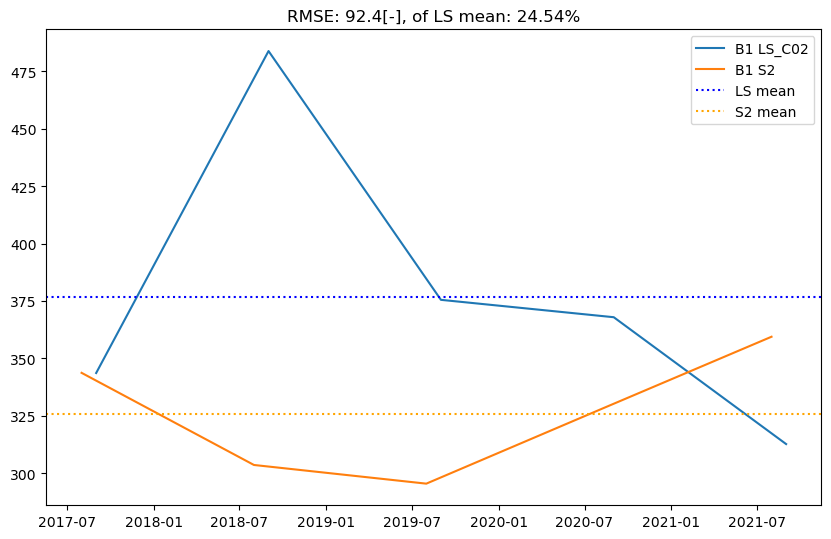

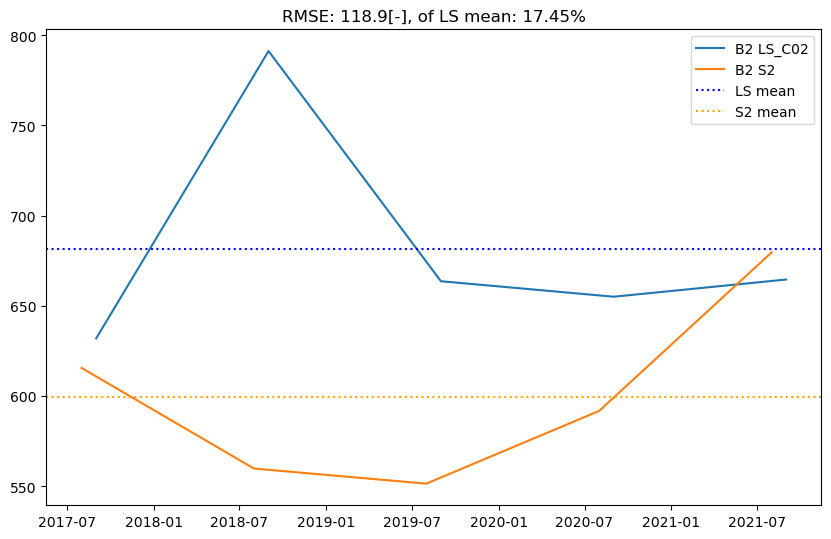

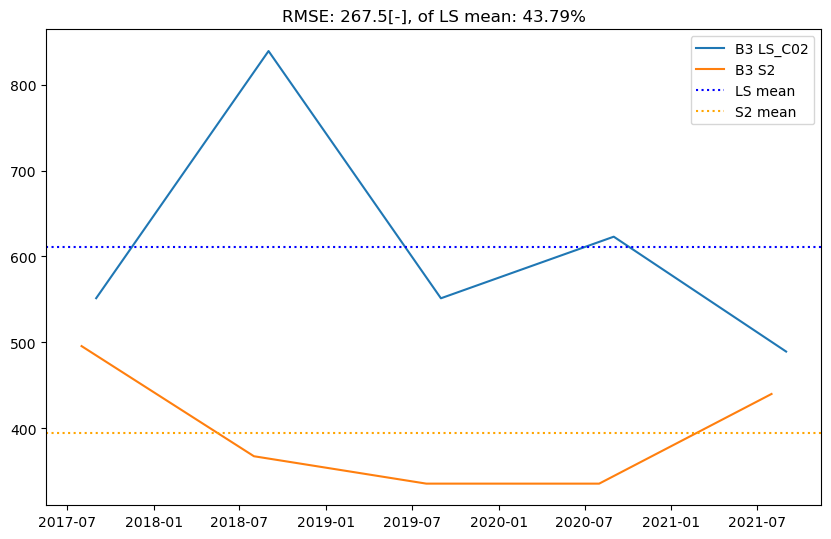

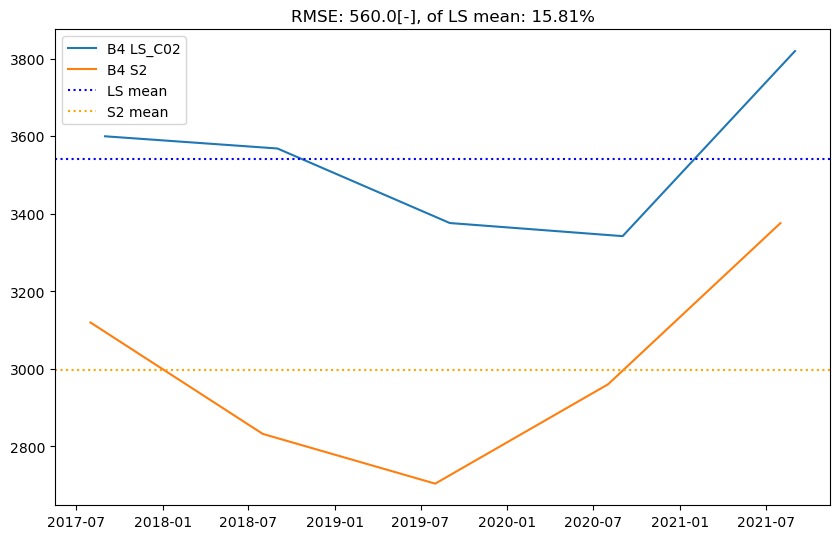

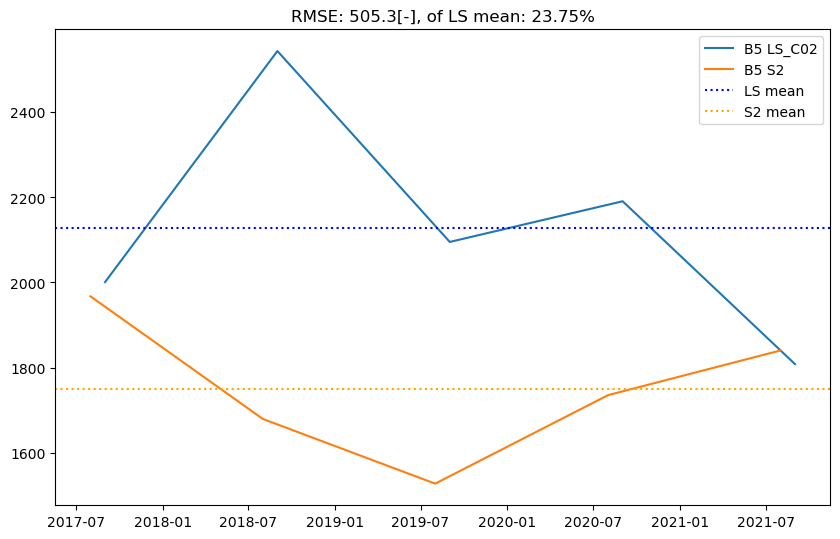

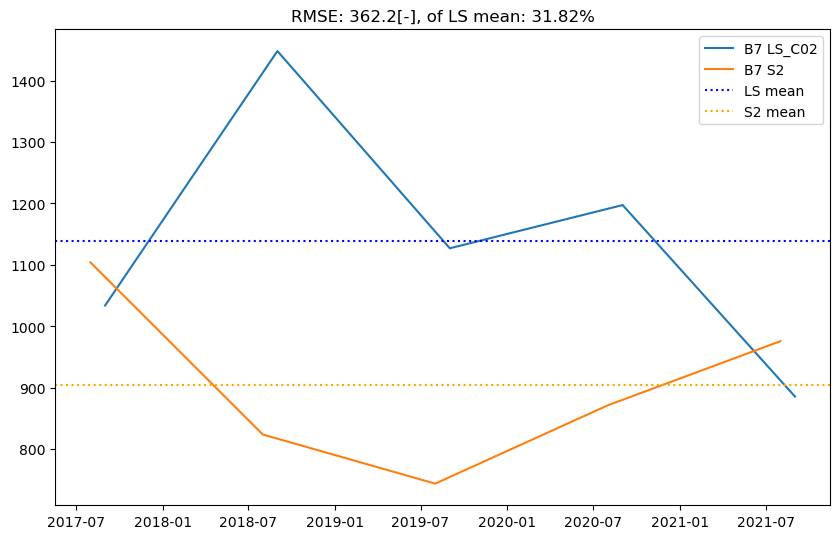

In [131]:
import matplotlib
count = 0

band_data_LS_2017 = band_data_LS.iloc[-6:-1, :-6]

for i in band_data_LS_2017.keys():
    count+=1
    ax = plt.figure(count, figsize=(10, 6.18))
    
    landsat = band_data_LS_2017
    
    sentinel = band_data_S2.iloc[0:-1]
    
    plt.title(i)
    plt.plot(landsat.loc[:, i], label = i+' LS_C02')
    plt.plot(sentinel.loc[:,i], label = i+' S2')
    RMSE = pandas_rmse(np.array(landsat.loc[:,i]), np.array(sentinel.loc[:,i]))
    #print(band_data_LS_2017.loc[:, i])
    #print(band_data_S2.loc[:, i])
    print(RMSE)
    LS_mean = np.mean(np.array(landsat.loc[:, i]))
    S2_mean = np.mean(np.array(sentinel.loc[:, i]))
    LS_pct = RMSE / LS_mean *100
    plt.axhline(LS_mean, linestyle=':', label = 'LS mean', color='blue')
    plt.axhline(S2_mean, linestyle=':', label = 'S2 mean', color='orange')
    plt.title(f'RMSE: {RMSE:.1f}[-], of LS mean: {LS_pct:.2f}%')
    plt.legend()
#ax.set_xticks([S2_indices.index.strftime('%Y') for x in xticks])
plt.xticks()
;

In [ ]:
LS_band_stats = band_data_LS.iloc[-6:-1, :].describe()
LS_band_stats

In [ ]:
LS_band_stats = band_data_S2.iloc[0:-1].describe()
LS_band_stats

In [ ]:
def normalized_difference(B1, B2):
    normalized_difference_calc = ((B1-B2)/(B1+B2))
    #if np.any(normalized_difference_calc < 0):
    #    return normalized_difference_calc * -1
    #else:
    return normalized_difference_calc

def EVI(NIR, RED, BLUE):
    EVI_calc = 2.5*(NIR-RED) / (NIR + 6*RED - 7.5*BLUE + 1)
    return EVI_calc #*100

def ND_to_df(df, index = []):
    if np.any(np.char.lower(index) == 'all'):
        index = ['NDVI', 'EVI', 'NBR', 'NDMI', 'GNDVI', 'NDBI']   
    
    if np.any(np.char.lower(index) == 'ndvi'):
        df['NDVI'] =  normalized_difference(df.B1, df.B2) # NDVI is normalized difference between NIR band4 and red band3

    if np.any(np.char.lower(index) == 'evi') or np.any(index == 'all'):
        df['EVI'] =  EVI(df.B4, df.B3, df.B1)
    
    if np.any(np.char.lower(index) == 'nbr') or np.any(index == 'all'):
        df['NBR'] =  normalized_difference(df.B4, df.B7) #NBR is NIR band 4 and SWIR2 band 7
    
    if np.any(np.char.lower(index) == 'ndmi') or np.any(index == 'all'):
        df['NDMI'] =  normalized_difference(df.B4, df.B5) #NDMI is NIR band 4 and SWIR1 band 5
    
    if np.any(np.char.lower(index) == 'gndvi') or np.any(index == 'all'):
        df['GNDVI'] =  normalized_difference(df.B4, df.B2) #GNDVI is NIR band 4 and green band 2
    
    if np.any(np.char.lower(index) == 'ndbi') or np.any(index == 'all'):
        df['NDBI'] =  normalized_difference(df.B5, df.B4) #NDBI is SWIR1 B5 and NIR B4
   
    
    return df

def plot_keys_matrix(df1, df2, title, fignum, label1, label2):
    fig = plt.figure(fignum, figsize=(20, 20))
    plt.suptitle(title)

    a = 0

    for row in df1.keys():
        for col in df1.keys():
            a+=1
            fig.add_subplot(6, 6, a).set_title(f'{row} x {col}')
            plt.scatter(df1.loc[:, row], df1.loc[:, col], label=label1)
            plt.scatter(df2.loc[:, row], df2.loc[:, col], label=label2)
            plt.legend()
            

In [ ]:
list_of_indices = ['ALL']

In [ ]:
fignum = 100

#add normalised difference indices to the dataframe

LS_normalized_diff = ND_to_df(band_data_LS, list_of_indices).iloc[0:-1, -6:]

S2_normalized_diff = ND_to_df(band_data_S2, list_of_indices).iloc[0:-1, -6:]

In [ ]:
plot_keys_matrix(LS_normalized_diff, S2_normalized_diff, 'collection comparison', 10, 'ls', 's2') #plot a matrix


plt.tight_layout()

In [185]:
LS_normalized_diff.iloc[:, -6:]

,NDVI,EVI,NBR,NDMI,GNDVI,NDBI
1984-08-31 22:00:00,-0.162055,1.625107,0.478769,0.242825,0.560784,-0.242825
1985-08-31 22:00:00,-0.318225,1.664431,0.581893,0.305707,0.692646,-0.305707
1986-08-31 22:00:00,-0.247922,1.734945,0.571150,0.330472,0.634557,-0.330472
1987-08-31 22:00:00,-0.240887,1.826668,0.632047,0.352301,0.661990,-0.352301
1988-08-31 22:00:00,-0.307692,1.709127,0.554633,0.274170,0.650514,-0.274170
1989-08-31 22:00:00,-0.299259,1.340561,0.470802,0.237581,0.593511,-0.237581
1990-08-31 22:00:00,-0.175273,2.291458,0.640895,0.346618,0.653219,-0.346618
1991-08-31 22:00:00,-0.249476,1.578872,0.500451,0.239386,0.646221,-0.239386
1992-08-31 22:00:00,-0.220571,1.552336,0.548802,0.306512,0.531476,-0.306512
1993-08-31 22:00:00,-0.160879,2.167741,0.609232,0.346978,0.622581,-0.346978


***
<a id="Land_Cover"></a>
## Land Cover 

[Linking Reference to Land Cover](#Land_cover)

In [10]:
Map = geemap.Map()
Map.add_basemap('HYBRID')
Map.addLayer(aoi, {}, 'ROI')
Map.centerObject(aoi, 12)
Map

NameError: name 'aoi' is not defined

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…